# 24. mlflow 다양한 실험2

----
* 다루는 내용
    * auto log
    * xgboost
    * keras
----

## 1.환경준비

### (1) 라이브러리 Import

* 설치할 라이브러리

In [ ]:
!pip install xgboost

In [ ]:
!pip install tensorflow
!pip install keras

* 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

import mlflow

### (2) 데이터 불러오기

* 카시트 판매량 데이터

|	변수명	|	설명	|	구분	|
|----|----|----|
|	**Sales** 	|	 **각 지역 판매량(단위 : 1000개)**	|	**Target**	|
|	CompPrice 	|	지역별 경쟁사 판매가격(달러)	|	feature	|
|	Income 	|	가구당 평균 소득액(1000달러)	|	feature	|
|	Advertising 	|	 각 지역, 회사의 광고 예산(1000달러)	|	feature	|
|	Population 	|	 지역 인구수(단위 : 1000명)	|	feature	|
|	Price 	|	 자사 지역별 판매가격(달러)	|	feature	|
|	ShelveLoc 	|	 진열상태(범주 : Bad, Medium, Good)	|	feature	|
|	Age 	|	 지역 인구의 평균 연령	|	feature	|
|	Education 	|	 교육수준(범주 : 10~18)	|	feature	|
|	Urban 	|	 매장이 도심에 있는지 여부(범주 : Yes, No)	|	feature	|
|	US 	|	 매장이 미국에 있는지 여부(범주 : Yes, No)	|	feature	|


* 데이터 경로 : https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv

In [2]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
carseat = pd.read_csv(path)
carseat.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## 2. 전처리 및 추적 준비

### (1) 데이터 전처리

* 데이터 준비

In [3]:
target = 'Sales'
x = carseat.drop(target, axis=1)
y = carseat.loc[:, target]

* 가변수화

In [4]:
cat_cols = {'ShelveLoc':['Bad','Medium','Good']
            , 'Education':[10,11,12,13,14,15,16,17,18]
            , 'US':['No','Yes']
            , 'Urban':['No','Yes']}

for var, values in cat_cols.items():
    x[var] = pd.Categorical(x[var], categories = values)

x = pd.get_dummies(x, columns = cat_cols.keys(), drop_first = True)    

* 데이터분할

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

* 스케일링

In [6]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### (2) Tracking 준비

#### 1) 추적설정

In [7]:
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

#### 2) 새 실험 만들기

In [8]:
exp_id = mlflow.create_experiment("exp4")
exp_id

2023/04/12 16:10:40 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/04/12 16:10:40 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


'4'

## 3. autolog : XGBoost

In [17]:
from xgboost import XGBRegressor

### (1) XGB 모델링

* 모델링
    * early_stopping 기능이 제공됩니다.
    * .fit 에 검증셋을 함께 입력하여 검증할 수 있습니다.

In [18]:
model = XGBRegressor(n_estimators=100, objective="reg:squarederror",
                     learning_rate=0.1, early_stopping_rounds=10)

eval_set = [(x_train, y_train), (x_val, y_val)]
model.fit(x_train, y_train, eval_set=eval_set)

[0]	validation_0-rmse:6.85813	validation_1-rmse:6.83002
[1]	validation_0-rmse:6.23220	validation_1-rmse:6.22894
[2]	validation_0-rmse:5.66902	validation_1-rmse:5.70176
[3]	validation_0-rmse:5.16165	validation_1-rmse:5.25441
[4]	validation_0-rmse:4.70303	validation_1-rmse:4.83492
[5]	validation_0-rmse:4.29028	validation_1-rmse:4.47706
[6]	validation_0-rmse:3.91628	validation_1-rmse:4.15741
[7]	validation_0-rmse:3.57998	validation_1-rmse:3.86995
[8]	validation_0-rmse:3.27359	validation_1-rmse:3.61345
[9]	validation_0-rmse:2.99782	validation_1-rmse:3.37225
[10]	validation_0-rmse:2.74822	validation_1-rmse:3.17815
[11]	validation_0-rmse:2.52315	validation_1-rmse:3.00625
[12]	validation_0-rmse:2.31932	validation_1-rmse:2.84555
[13]	validation_0-rmse:2.13497	validation_1-rmse:2.70712
[14]	validation_0-rmse:1.96667	validation_1-rmse:2.58429
[15]	validation_0-rmse:1.81690	validation_1-rmse:2.48469
[16]	validation_0-rmse:1.67716	validation_1-rmse:2.40113
[17]	validation_0-rmse:1.55336	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

* 모델링 후 최적의 iteration과 그때의 검증성능 확인

In [19]:
# best iter, best score
print(model.best_iteration, model.best_score)

65 1.795728762452082


* 각 iteration의 검증 성능을 데이터프레임으로 저장하고 그래프로 확인하기 

In [20]:
# iteration 수에 따른 성능
result = pd.DataFrame({'train_err':model.evals_result_['validation_0']['rmse'],
                       'val_err':model.evals_result_['validation_1']['rmse']}  )
result

,train_err,val_err
0,6.858129,6.830021
1,6.232201,6.228939
2,5.669022,5.701762
3,5.161652,5.254407
4,4.703032,4.834918
...,...,...
71,0.211630,1.799628
72,0.205383,1.800707
73,0.201603,1.800579
74,0.199709,1.800205


* 학습곡선

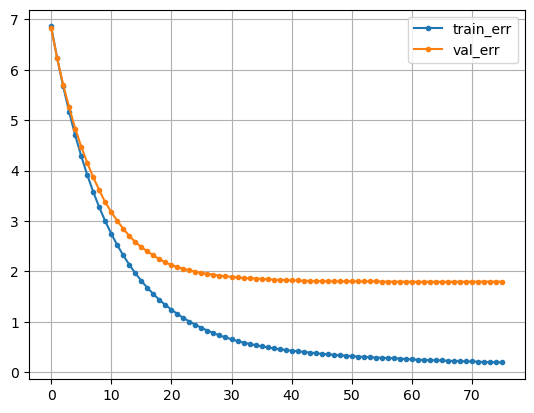

In [21]:
plt.plot('train_err', data = result, marker = '.', label = 'train_err' )
plt.plot('val_err', data = result, marker = '.', label = 'val_err' )
plt.legend()
plt.grid()
plt.show()

### (2) autolog
* 이제 xgb 코드를 넣고 자동 로깅을 해 봅시다.

In [22]:
with mlflow.start_run(experiment_id=exp_id, run_name = 'xgb_autolog'):
    
    mlflow.xgboost.autolog()
    model = XGBRegressor(n_estimators=100, objective="reg:squarederror",
                     learning_rate=0.1, early_stopping_rounds=10)

    eval_set = [(x_train, y_train),(x_val, y_val)]
    model.fit(x_train, y_train, eval_set = eval_set )
    
    mlflow.xgboost.log_model(model, "model", registered_model_name="XGB")
    
    mlflow.xgboost.autolog(disable = True)

2023/04/12 17:13:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


[0]	validation_0-rmse:6.85813	validation_1-rmse:6.83002
[1]	validation_0-rmse:6.23220	validation_1-rmse:6.22894
[2]	validation_0-rmse:5.66902	validation_1-rmse:5.70176
[3]	validation_0-rmse:5.16165	validation_1-rmse:5.25441
[4]	validation_0-rmse:4.70303	validation_1-rmse:4.83492
[5]	validation_0-rmse:4.29028	validation_1-rmse:4.47706
[6]	validation_0-rmse:3.91628	validation_1-rmse:4.15741
[7]	validation_0-rmse:3.57998	validation_1-rmse:3.86995
[8]	validation_0-rmse:3.27359	validation_1-rmse:3.61345
[9]	validation_0-rmse:2.99782	validation_1-rmse:3.37225
[10]	validation_0-rmse:2.74822	validation_1-rmse:3.17815
[11]	validation_0-rmse:2.52315	validation_1-rmse:3.00625
[12]	validation_0-rmse:2.31932	validation_1-rmse:2.84555
[13]	validation_0-rmse:2.13497	validation_1-rmse:2.70712
[14]	validation_0-rmse:1.96667	validation_1-rmse:2.58429
[15]	validation_0-rmse:1.81690	validation_1-rmse:2.48469
[16]	validation_0-rmse:1.67716	validation_1-rmse:2.40113
[17]	validation_0-rmse:1.55336	validation

2023/04/12 17:13:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\hanky\anaconda3\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Successfully registered model 'XGB'.
2023/04/12 17:13:49 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to fini

* mlflow ui로 가서 어떤 것들이 저장되었는지 살펴 봅시다.
* 추가로 더 저장할만한 것은 무엇이 있을까요?